# MultiClass Dog Breed Classifier

## Problem

Identify the breed of dog given an image of a dog.

## Data 

The dataset is from Kaggle's Dog Breed Identification competition (https://www.kaggle.com/c/dog-breed-identification/overview/description)

## Evaluation 

For each image in the test set, you must predict a probability for each of the different breeds. (https://www.kaggle.com/c/dog-breed-identification/overview/evaluation)

## Features

* Data contains 120 breeds of dogs 
* Data is unstructured (images)
* Data has 10,000+ rows in both the training and testing set. 


In [147]:
#!unzip "/content/drive/My Drive/Data/dog-breed-identification.zip" -d "/content/drive/My Drive/Data"


### importing libraries and setting up workspace 

In [148]:
import tensorflow as tf 
import tensorflow_hub as hub 

### Turning our data into tensors 


In [149]:
import pandas as pd 
import numpy as np
import matplotlib as plt

labels = pd.read_csv('/content/drive/My Drive/Data/labels.csv') 



The median value for the number of dog images is: 82.0


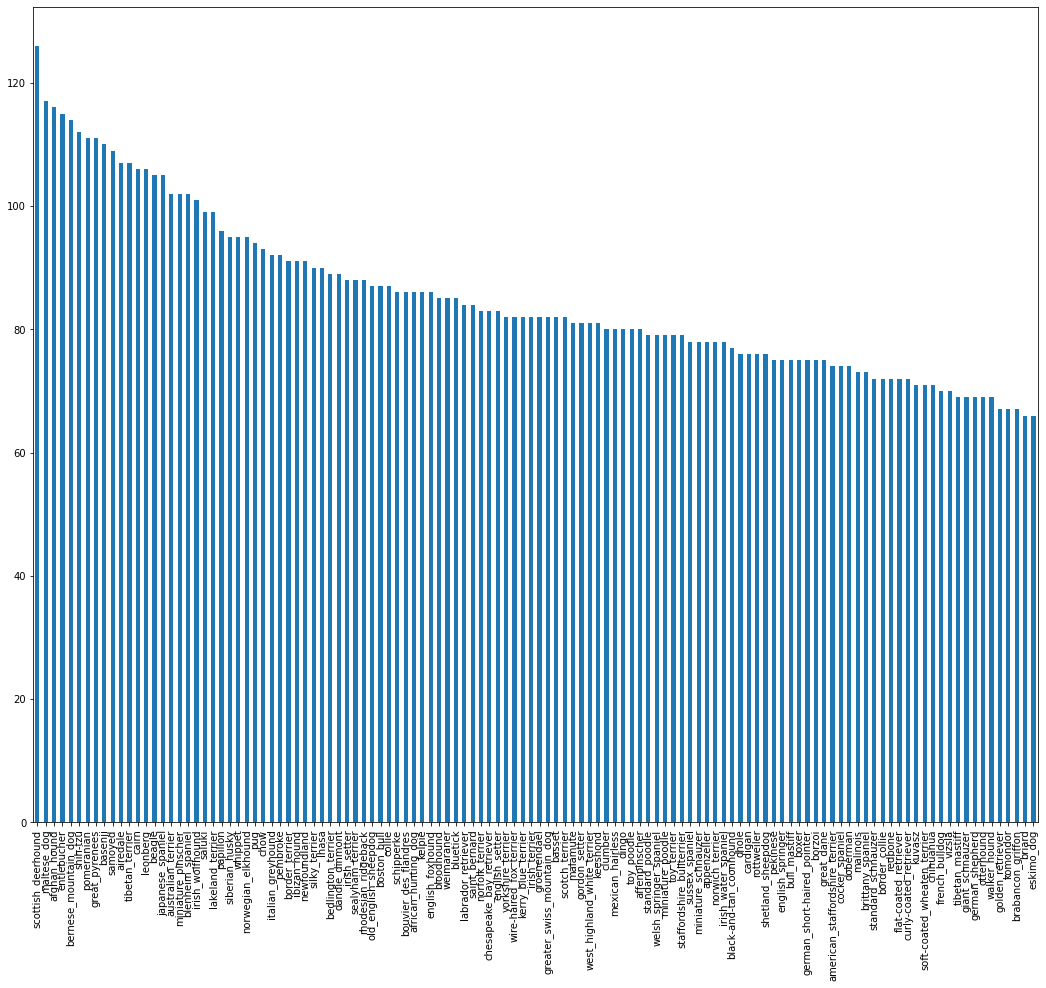

In [150]:
#visualizing the the number of dog images in each bread
labels['breed'].value_counts().plot(kind='bar',figsize=(18,15))

print('The median value for the number of dog images is: ' + str(labels['breed'].value_counts().median()))

In [151]:
from IPython.display import Image

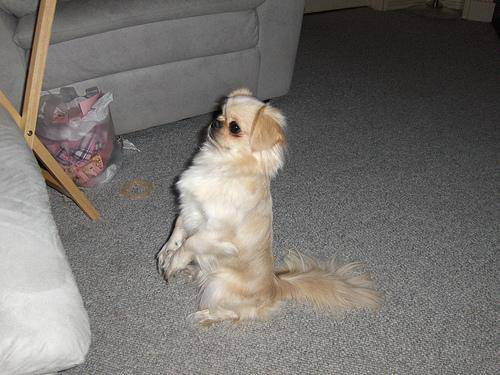

In [152]:
Image('/content/drive/My Drive/Data/train/001cdf01b096e06d78e9e5112d419397.jpg')

## Getting images and their labels 

In [153]:

filename = ['/content/drive/My Drive/Data/train/' + fname + '.jpg' for fname in labels['id']]

import os

#checking if the number of filename = the number of files in train folder

print(len(os.listdir('/content/drive/My Drive/Data/train')) == len(filename)) 

True


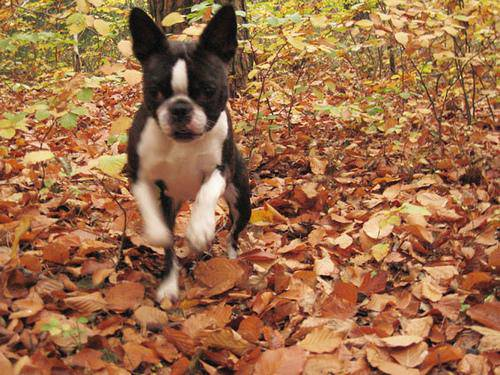

In [154]:
Image(filename[0])

In [155]:
breeds = labels['breed']

#list of unique breeds
uniques = breeds.unique()

boolean_breads = [breed == uniques for breed in breeds]


In [156]:
# Turning the labels into numbers 
boolean_breads[0].astype(int)

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [157]:
X = filename 
y = boolean_breads

### We will test things using 1000 images

In [158]:
NUM = 1000


In [159]:
#Splitting the data into training and validation

from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split( X[:NUM], y[:NUM], test_size=0.2, random_state=42)

#Checking the split
len(X_train), len(X_val), len(y_train), len(y_val)

(800, 200, 800, 200)

# Preprocessing Data (Images to Tensors)
#### To preprocess the images we will build a function that does the following: 
1. Take filepath as input 
2. Use Tensorflow to read the file and save it in a variable
3. Turn Image into Tensor 
4. Resize image shape (244,244) 
5. Return modified image

In [160]:
from matplotlib.pyplot import imread

image = imread(filename[23])

image.shape

(210, 291, 3)

##Building the function mentioned earlier

In [161]:
# Define Image size

IMAGE_SIZE = 224

def Image_preprocess(imagepath,img_size = IMAGE_SIZE):
  '''
  Takes an image file path and turns Image into tensor 
  '''
  #Read Image
  image = tf.io.read_file(imagepath)
  #Convert the jpeg image into a numerical tensor
  image = tf.image.decode_jpeg(image, channels=3) 
  #Convert image color channels from 0-255 to 0-1 (Normalization)
  image = tf.image.convert_image_dtype(image, tf.float32)
  #Resize the image (224,244)
  image =  tf.image.resize(image, size = [IMAGE_SIZE,IMAGE_SIZE])

  return image






## Turning the data into Batches of 32

In [162]:
#create a simple function to return a tuple 

def get_image_label(imagepath, label):
  '''
  Takes the image and its label then puts them into one tuple
  '''
  image = Image_preprocess(imagepath)
  return image,label

In [163]:
def create_data_batches(X,y=None,batch_size=32,valid_data=False, test_data=False):
  '''
  creats batches from the data's images X and labels y
  Shuffle data for training set and do not shuffle for validation set
  Also test data as input (no labels)
  '''
  if test_data:
    print('Creating test data batches...')
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X)))
    data_batch = data.map(get_image_label).batch(32)
    return data_batch
  elif valid_data:
    print('Creating valid data batches....')
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),tf.constant(y)))
    data_batch = data.map(get_image_label).batch(32)
    return data_batch
  else: 
    print('Creating train data batches...')

    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),tf.constant(y)))
    data = data.shuffle(buffer_size=len(X))
    data = data.map(get_image_label)
    data_batch = data.batch(32)
    return data_batch

In [164]:
train_data = create_data_batches(X_train,y_train)
valid_data = create_data_batches(X_val,y_val)

Creating train data batches...
Creating train data batches...


In [165]:
train_data.element_spec , valid_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

## Visualizing Our Data 

In [191]:
import matplotlib.pyplot as plt

#Create a function to view our data 
def show_25_images(image, label):
  '''
  Displays 25 images and their labels using matplotlib
  '''

  #setup the figure
  plt.figure(figsize=(12,15))
  #loop over 25 images
  for i in range(25):
  #Create a subplot 5 x 5 
   ax = plt.subplot(5,5,i+1)
  #Display an image
   plt.imshow(image[i])
  #Add the image label as title
   plt.title(uniques[label[i].argmax()])
  #Turn off the grid for a better view 
   plt.axis('off')

In [195]:
train_images, train_label = next(train_data.as_numpy_iterator())
valid_images,valide_label = next(valid_data.as_numpy_iterator())

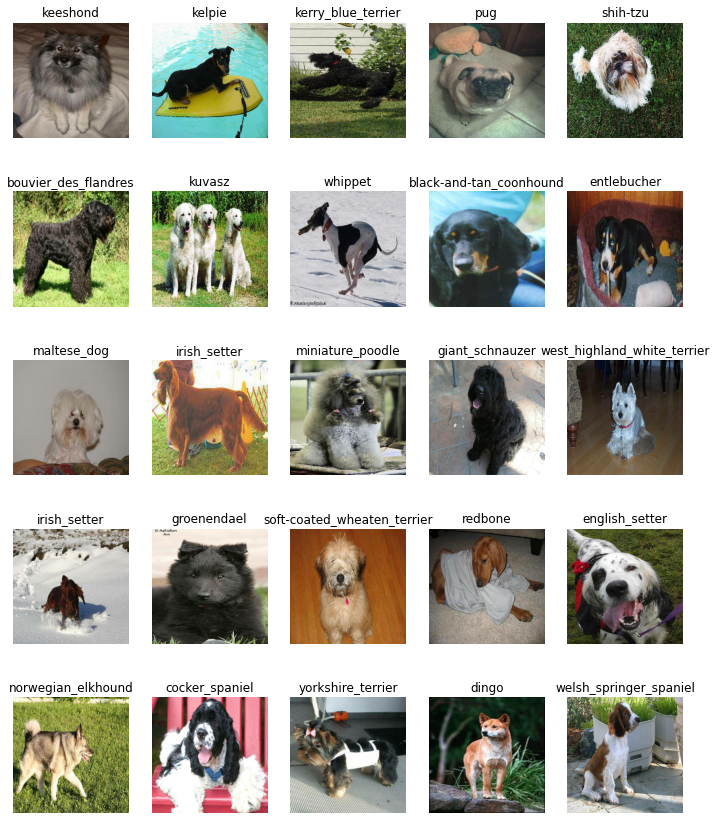

In [196]:
show_25_images(train_images,train_label)


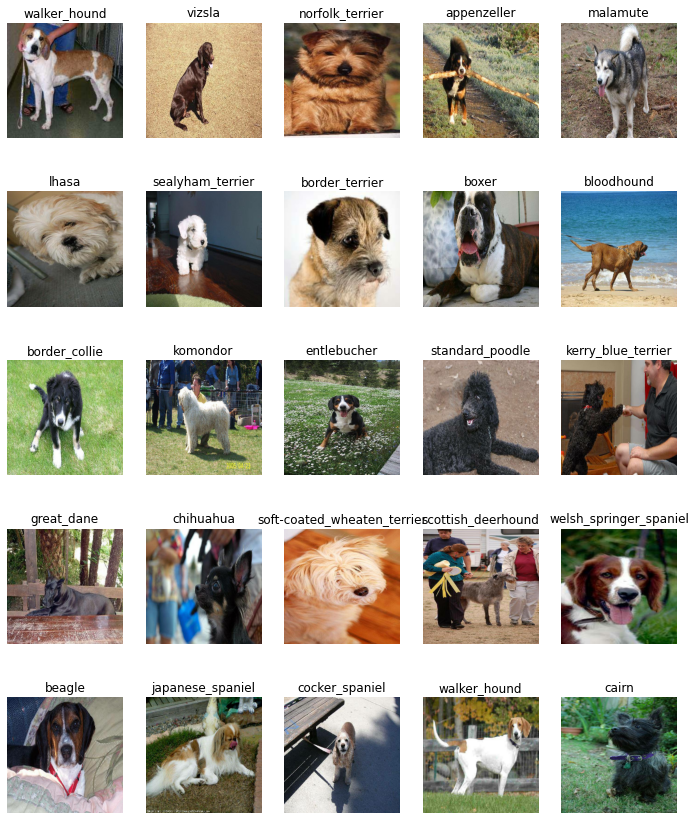

In [197]:
show_25_images(valid_images,valide_label)